In [1]:
# First, let us get started
!git clone https://github.com/chufangao/CTOD.git
!git clone https://github.com/futianfan/clinical-trial-outcome-prediction.git
!wget https://huggingface.co/datasets/chufangao/CTO/resolve/main/CTTI.zip
CTTI_PATH = './CTTI.zip'

Cloning into 'CTOD'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 541 (delta 193), reused 150 (delta 79), pack-reused 231 (from 1)
Receiving objects: 100% (541/541), 34.29 MiB | 8.43 MiB/s, done.
Resolving deltas: 100% (293/293), done.
Cloning into 'clinical-trial-outcome-prediction'...
remote: Enumerating objects: 932, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 932 (delta 19), reused 40 (delta 5), pack-reused 863 (from 1)
Receiving objects: 100% (932/932), 104.38 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (534/534), done.
Updating files: 100% (119/119), done.
--2025-02-27 10:37:49--  https://huggingface.co/datasets/chufangao/CTO/resolve/main/CTTI.zip
Resolving huggingface.co (huggingface.co)... 3.167.112.45, 3.167.112.38, 3.167.112.25, ...
Connecting to huggingface.co (huggingface.co)|3.167.112.45|:44

# Visualizing Overall Statistics

<ipython-input-13-499515309637>:15: DtypeWarning: Columns (46,47,48,53,68) have mixed types. Specify dtype option on import or set low_memory=False.
  studies_df = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='studies.txt'][0]), sep='|', parse_dates=['start_date','completion_date'])


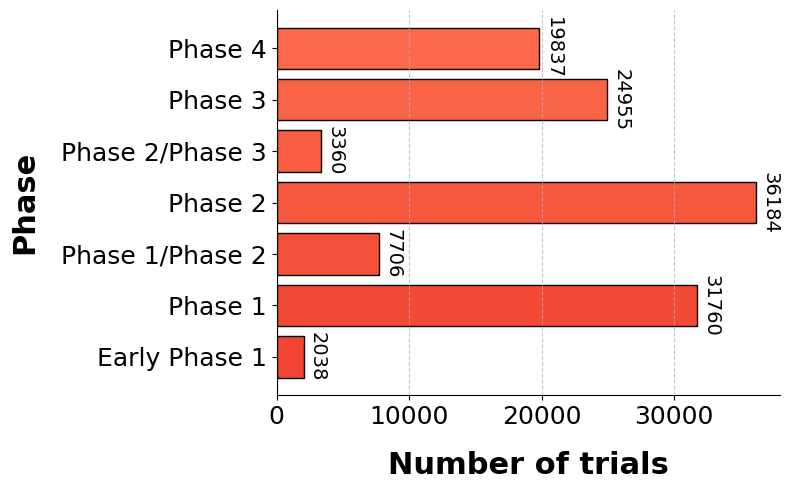

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
import json
import os
import matplotlib.ticker as mticker

def drug_biologics_nct_ids_in_CTO(CTTI_PATH):
    import zipfile
    with zipfile.ZipFile(CTTI_PATH, 'r') as zip_ref:
        names = zip_ref.namelist()
        studies_df = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='studies.txt'][0]), sep='|', parse_dates=['start_date','completion_date'])
        interventions = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='interventions.txt'][0]), sep='|')

    interventions = interventions[['nct_id','intervention_type']]
    type_list = ['drug','biological']
    interventions = interventions[interventions['intervention_type'].str.lower().isin(type_list)]

    studies_df = studies_df[studies_df['overall_status'].str.lower().isin(['terminated', 'withdrawn', 'suspended', 'withheld', 'no longer available', 'temporarily not available', 'approved for marketing', 'completed'])]
    studies_df.dropna(subset=['phase'], inplace=True)

    studies_df = studies_df[studies_df['nct_id'].isin(interventions['nct_id'])]
    # also subset interventions
    interventions = interventions[interventions['nct_id'].isin(studies_df['nct_id'])]
    return studies_df, interventions


# filter out the trials that are not drug or biological
studies_df, interventions_df = drug_biologics_nct_ids_in_CTO(CTTI_PATH)
studies_df = studies_df[['nct_id','official_title','phase','start_date','completion_date','brief_title']]

phase_group_list = ['EARLY_PHASE1','PHASE1','PHASE1/PHASE2','PHASE2','PHASE2/PHASE3','PHASE3','PHASE4']#,'MISSING']
# get the count of trial in each phase
phase_total_count = [studies_df[studies_df['phase'] == phase].shape[0] for phase in phase_group_list]

phase_group_list = ['Early Phase 1','Phase 1','Phase 1/Phase 2','Phase 2','Phase 2/Phase 3','Phase 3','Phase 4']#,'Missing']

# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(phase_group_list, phase_total_count, color=plt.cm.Reds(np.linspace(0.6, 0.5,  len(phase_group_list))), edgecolor='black') #'#DAE8FC'
#    plt.cm.Reds(np.linspace(0.6, 0.4,
# Adding labels on the right side of the bars
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),  # 3 points horizontal offset
                textcoords="offset points",
                ha='left', va='center',rotation=270,fontsize = 14)

# Adding gridlines
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.yaxis.grid(False)
# Setting labels and title with professional fonts
ax.set_xlabel('Number of trials', fontsize=22, labelpad=16,weight='bold')
ax.set_ylabel('Phase', fontsize=22, labelpad=16,weight='bold')
# ax.set_title('CTO Phase Distribution', fontsize=18, weight='bold', pad=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Adjusting tick parameters
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

# Tight layout to avoid extra spaces
plt.tight_layout()

# Save the plot
# plt.savefig(f'{save_plot_path}/CTO_phase_horizontal.png', dpi=300, bbox_inches='tight')
plt.show()


(119793, 2)
(118615, 2)


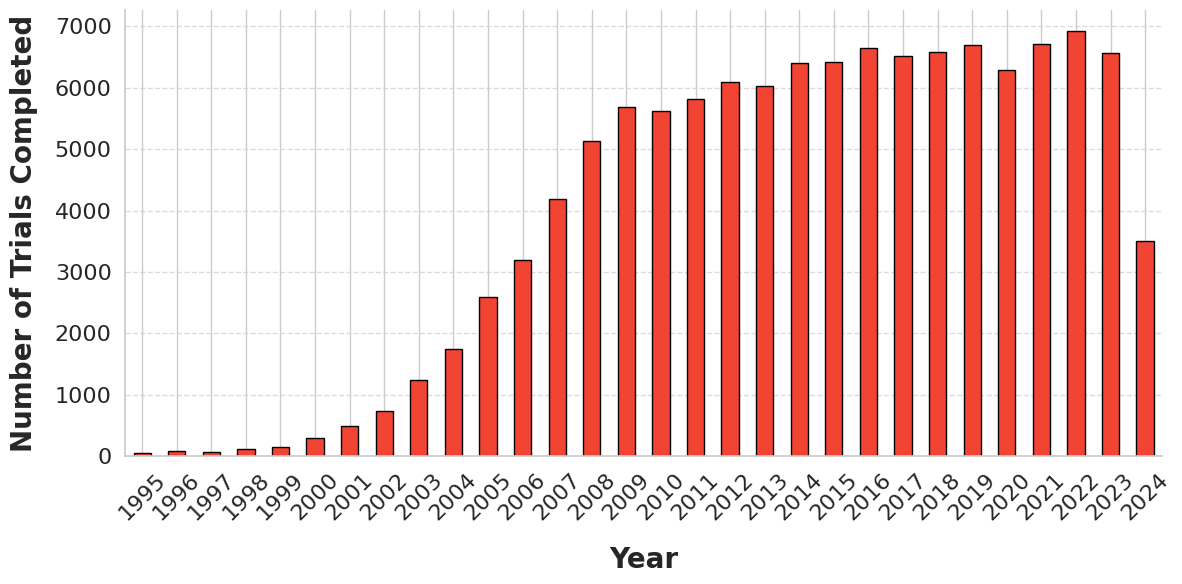

In [20]:

completion_time_df = studies_df[['nct_id','completion_date']]

# drop the trials with missing completion date
completion_time_df = completion_time_df.dropna()
print(completion_time_df.shape)

# drop trials completed date after 2024
completion_time_df = completion_time_df[completion_time_df['completion_date'] < pd.Timestamp('2024-11-01')]
completion_time_df = completion_time_df[completion_time_df['completion_date'] >= pd.Timestamp('1995-01-01')]
print(completion_time_df.shape)


# convert the completion date to year
completion_time_df['completion_year'] = completion_time_df['completion_date'].dt.year
completion_time_df

# Yearly counts
yearly_counts = completion_time_df['completion_year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
yearly_counts.plot(kind='bar', color=plt.cm.Reds(np.linspace(0.6, 0.6,  len(yearly_counts))), edgecolor='black') #'#F8CECC'
# plt.title('Count of Trials Completed Per Year')
plt.xlabel('Year', fontsize=20, labelpad=16,weight='bold')
plt.ylabel('Number of Trials Completed', fontsize=20, labelpad=12,weight='bold')
plt.xticks(rotation=45, fontsize=16, ha='center')
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# ax = plt.gca()
# ax.set_yscale('log')
plt.tight_layout()
# plt.savefig(f'{save_plot_path}/CTO_completion_year.png', dpi=300, bbox_inches='tight')
plt.show()

(131160, 25) Index(['nct_id', 'hint_train', 'hint_train2', 'hint_train3', 'status',
       'status2', 'gpt', 'gpt2', 'linkage', 'linkage2', 'stock_price',
       'results_reported', 'new_headlines', 'pvalues', 'update_more_recent',
       'sites', 'serious_ae', 'patient_drop', 'num_patients', 'death_ae',
       'amendments', 'all_ae', 'pred', 'pred_proba', 'num_sponsors'],
      dtype='object')
(131160, 16) Index(['nct_id', 'status', 'pvalues', 'gpt', 'linkage', 'new_headlines',
       'stock_price', 'results_reported', 'update_more_recent', 'sites',
       'serious_ae', 'patient_drop', 'num_patients', 'death_ae', 'amendments',
       'all_ae'],
      dtype='object')
(131160, 9)
26595
Trial Status Trial Status 20208
Trial Status P-values 898
Trial Status PubMed Abstracts 2961
Trial Status Trial Linkage 15024
Trial Status News Headlines 0
Trial Status Stock Price 30
Trial Status Serious AE 6354


<ipython-input-18-8759ca46721b>:56: RuntimeWarning: invalid value encountered in scalar divide
  agreement = (label_1_df[label] == label_2_df[label_2]).sum() / len(label_1_df)


Trial Status Amendments 30


<ipython-input-18-8759ca46721b>:56: RuntimeWarning: invalid value encountered in scalar divide
  agreement = (label_1_df[label] == label_2_df[label_2]).sum() / len(label_1_df)


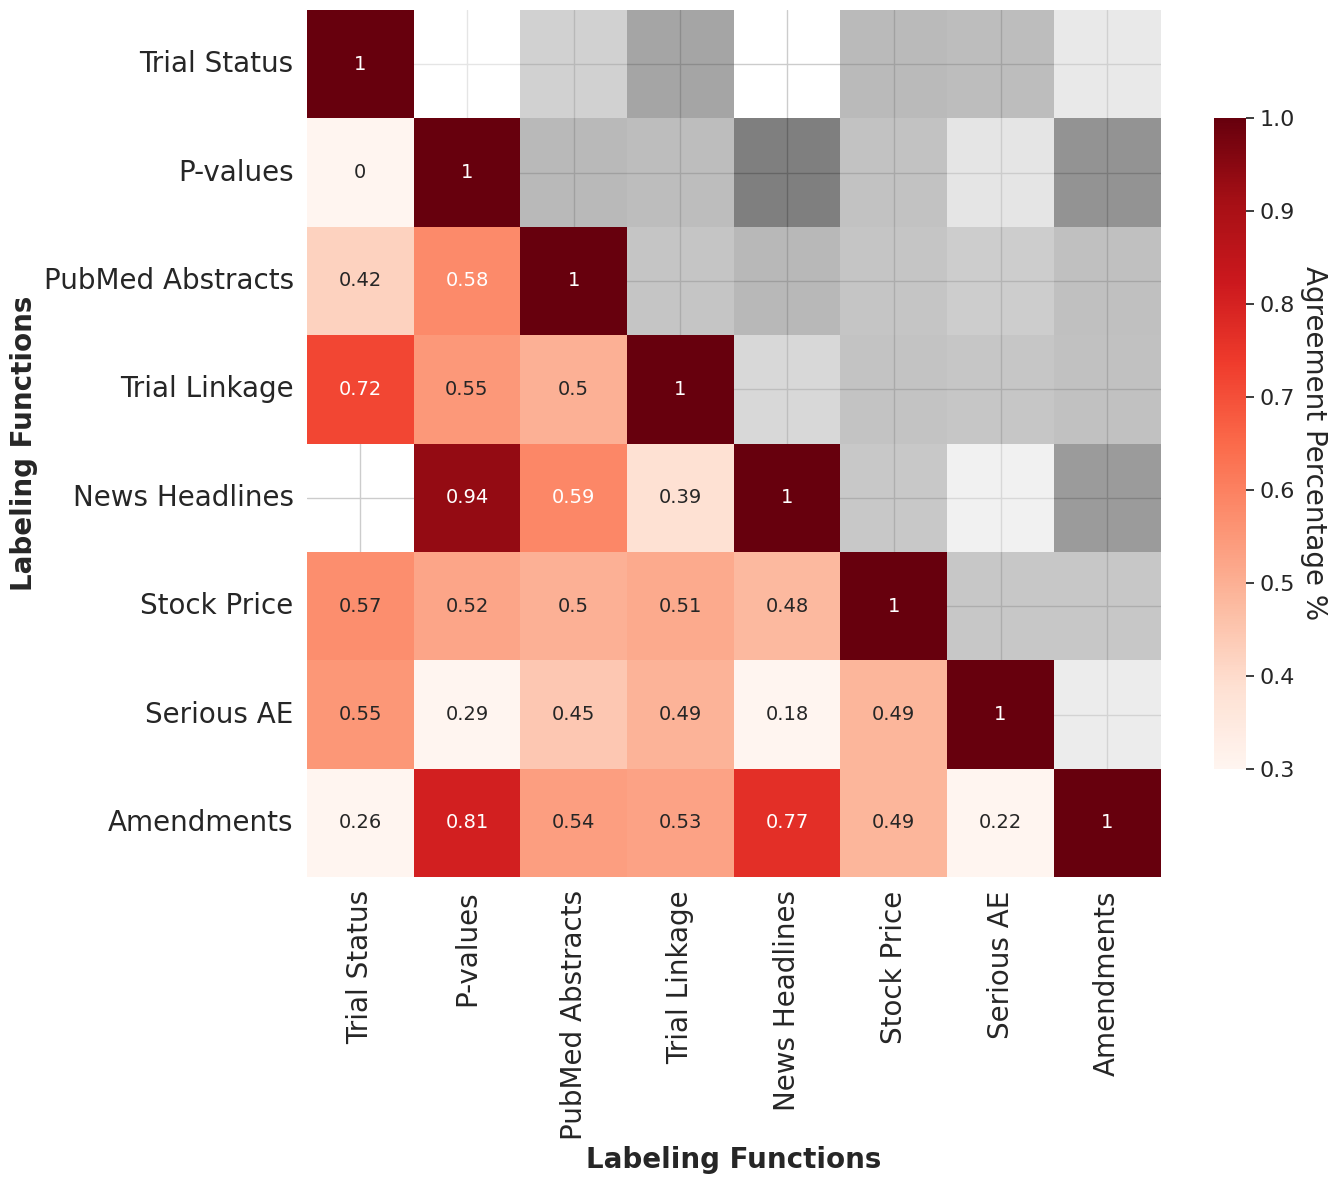

In [18]:
import glob

CTO_phase1_preds = pd.read_csv("https://huggingface.co/datasets/chufangao/CTO/raw/main/phase1_CTO_rf.csv")
CTO_phase2_preds = pd.read_csv("https://huggingface.co/datasets/chufangao/CTO/raw/main/phase2_CTO_rf.csv")
CTO_phase3_preds = pd.read_csv("https://huggingface.co/datasets/chufangao/CTO/raw/main/phase3_CTO_rf.csv")

# read all the csv files and combine them
label_df = pd.concat([CTO_phase1_preds, CTO_phase2_preds, CTO_phase3_preds])
print(label_df.shape, label_df.columns)
label_df = label_df[['nct_id','status','pvalues','gpt','linkage','new_headlines','stock_price','results_reported','update_more_recent',
                     'sites','serious_ae','patient_drop','num_patients','death_ae','amendments','all_ae']]
print(label_df.shape, label_df.columns)
#rename the columns
label_df.columns = ['nct_id','Trial Status','P-values','PubMed Abstracts','Trial Linkage','News Headlines','Stock Price','Results Reported','Update More Recent',
                    'Sites','Serious AE','Patient Drop','Number of Patients','Death AE','Amendments','All AE']

# select
label_df = label_df[['nct_id','Trial Status','P-values','PubMed Abstracts','Trial Linkage','News Headlines','Stock Price',
                    'Serious AE','Amendments']]

# change -1 to nan
# label_df = label_df.replace(-1,np.nan)
print(label_df.shape)

print(len(label_df[label_df['Trial Status']!= -1]))

import matplotlib
from matplotlib.colors import LinearSegmentedColormap

# Define the color dictionary using RGBA; you can adjust the control points as neede

coverage_matrix = pd.DataFrame(index=label_df.columns[1:], columns=label_df.columns[1:])

for label in label_df.columns[1:]:
    for label_2 in label_df.columns[1:]:
        label_1_df = label_df[['nct_id',label]]
        label_2_df = label_df[['nct_id',label_2]]
        # remove -1 from the labels
        label_1_df = label_1_df[label_1_df[label] != -1]
        label_2_df = label_2_df[label_2_df[label_2] != -1]

        # get the intersection of the nct_ids
        common_nctids = list(set(label_1_df['nct_id']).intersection(set(label_2_df['nct_id'])))
        if label == 'Trial Status':
            print(label, label_2, len(common_nctids))

        # get the labels for the common nct_ids
        label_1_df = label_1_df[label_1_df['nct_id'].isin(common_nctids)]
        label_2_df = label_2_df[label_2_df['nct_id'].isin(common_nctids)]

        #sort nct_ids
        label_1_df = label_1_df.sort_values('nct_id')
        label_2_df = label_2_df.sort_values('nct_id')

        #calculate percentage of agreement
        agreement = (label_1_df[label] == label_2_df[label_2]).sum() / len(label_1_df)
        # if len(label_1_df) == 0:
        #     agreement = 0

        coverage_matrix.loc[label, label_2] = agreement

coverage_matrix = coverage_matrix.astype(float)


# coverage_matrix = coverage_matrix.applymap(np.log1p)
mask = np.triu(np.ones_like(coverage_matrix, dtype=bool), k=1)
plt.figure(figsize=(14, 12))
sns.set(style='whitegrid')  # Set seaborn style

# Use 'viridis' colormap for better perceptual uniformity
heatmap = sns.heatmap(coverage_matrix,mask = mask, annot=True, cmap='Reds', annot_kws={"size": 14}, cbar_kws={"shrink": 0.75},norm=matplotlib.colors.Normalize(vmin=0.3, vmax=1.0))



# Customize the colorbar
colorbar = heatmap.collections[0].colorbar
colorbar.set_label('Agreement Percentage %', rotation=270, labelpad=24, fontsize=20)
colorbar.ax.tick_params(labelsize=16)
# Overlay heatmap for the masked area with a different color
sns.heatmap(coverage_matrix, mask=~mask, cmap='Greys', cbar=False, alpha=0.5)

# Customize the axes and title
# plt.title('Pairwise Agreement between Labeling Functions (Data Programming)', fontsize=16, fontweight='bold')
plt.xlabel('Labeling Functions', fontsize=20,weight='bold')
plt.ylabel('Labeling Functions', fontsize=20,weight='bold')

# Customize the tick labels
plt.xticks(rotation=90, ha='center', fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Adjust layout for better spacing
plt.tight_layout()
# plt.savefig(f'{save_plot_path}/CTO_labeling_function_agreement.png', dpi=300, bbox_inches='tight')